In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from keras import models
from keras.layers import Dense, Conv1D, Reshape, Flatten, Lambda
from keras.optimizers import Adam
from keras import backend as K

In [10]:
def add_decorate(x):
    '''
    편차 제곱을 x 마지막 차원에 일일이 붙여준다.
    '''
    # axis = -1은 마지막 차원을 지정한다.
    m = K.mean(x, axis=-1, keepdims=True)
    print("x.shape=", x.shape,"m.shape=", m.shape)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

add_decorate() / add_decorate_shape() 동작 예시

In [11]:
i = K.constant(np.array([1,2,3,4], dtype=np.float32))
x = add_decorate(i)
print(i.shape)
print(x.shape)

import tensorflow as tf
sess = tf.Session()
with sess.as_default():
    print(x.eval())

print(add_decorate_shape((10,1)))

x.shape= (4,) m.shape= (1,)
(4,)
(8,)
[1.   2.   3.   4.   2.25 0.25 0.25 2.25]
(10, 2)


In [12]:
lr = 2e-4 #0.0002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)

def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        '''
        ni_D : input width
        nh_D : discriminator hidden layer width
        nh_G : generator의 hidden layer width
        '''
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G
        
        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()
        
    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = models.Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(nh_D, activation='relu'))
        D.add(Dense(1, activation='sigmoid'))
        
        model_compile(D)
        return D
    
    def gen_G(self):
        ni_D = self.ni_D
        nh_G = self.nh_G
        
        G = models.Sequential()
        '''
        Conv1D 동작관련
        https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
        '''
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,))) #(n,)를 (n,1)로 변경
        G.add(Conv1D(nh_G, 1, activation='relu')) #filters, kernel_size
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))
        G.add(Conv1D(1,1)) # (batch, ni_D, 1)
        G.add(Flatten())
        
        model_compile(G)
        return G
    
    def make_GD(self):
        G, D = self.G, self.D
        GD = models.Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True #원복
        return GD
    
    def D_train_on_batch(self, real, generated):
        D = self.D
        X = np.concatenate([real, generated], axis=0)
        y = np.array([1] * real.shape[0] + [0] * generated.shape[0])
        D.train_on_batch(x=X, y=y)
        
    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)
        

        

In [13]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        '''
        저정된 평균/편차를 가진 정규분포에서 추출한 100열 데이터를 원본으로 하고
        그냥 랜덤하게 뽑은 것을 입력으로 한다.
        '''
        self.real_sample = lambda n_batch : np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch : np.random.rand(n_batch, ni_D)
        


In [23]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25
        
        self.n_iter_D = 1
        self.n_iter_G = 5
        
        # 분산에 필요한 평균/표준편차 값을 초기화해서 Data를 생성
        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)
        
        self.n_batch = n_batch
        
    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        
        #real data
        real = data.real_sample(n_batch) #(n_batch, ni_D)
        
        #generate data
        Z = data.in_sample(n_batch)
        generated = gan.G.predict(Z) # (n_batch, ni_D)
        
        gan.D.trainable = True
        gan.D_train_on_batch(real, generated)
        
    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        
        #seed data for data generation
        Z = data.in_sample(n_batch)
        
        gan.D.trainable = False # ??? 왜 중복해서?
        gan.GD_train_on_batch(Z)
        
    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()
            
    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()
            
    def test(self, n_test):        
        # generate new image
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        generated = gan.G.predict(Z)
        return generated, Z # 생성된 이미지, 원본 입력 이미지(거의 노이즈)
    
    def show_hist(self, real, generated, Z):
        plt.hist(real.reshape(-1), histtype='step', label='Real')
        plt.hist(generated.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0) # Place a legend on the axes. loc=0 : location to best        
    
    def test_and_show(self, n_test):
        data = self.data
        generated, Z = self.test(n_test)
        real = data.real_sample(n_test)
        self.show_hist(real, generated, Z)
        Machine.print_stat(real, generated)
        
        generated, Z = self.test(10)
        print("Z.shape:", Z.shape)
        print(generated.shape)
        
    def run_epochs(self, epochs, n_test):
        '''
        train GAN and show the results
        for showing, the original and the artificial results will be compared
        '''
        self.train(epochs)
        self.test_and_show(n_test)
        
    def run(self, n_repeat=200, n_show=200, n_test=100):
        for i in range(n_repeat):
            print("Stage", i, '(Epoch:{})'.format(i * n_show))
            self.run_epochs(n_show, n_test)
            plt.show()
            
        generated, Z = self.test(n_test)
        print(generated.shape)
            
    @staticmethod
    def print_stat(real, generated):
        def stat(d):
            return (np.mean(d), np.std(d))
        
        print('Mean and Std of Real:', stat(real))
        print('Mean and Std of Gen:', stat(generated))
        

In [24]:
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=100, n_show=100, n_test=100)
    
    

x.shape= (?, 100) m.shape= (?, 1)
x.shape= (?, ?) m.shape= (?, 1)
Stage 0 (Epoch:0)
Mean and Std of Real: (4.018606136036979, 1.2431971264426664)
Mean and Std of Gen: (1.1650813, 0.6656795)
Z.shape: (10, 100)
(10, 100)


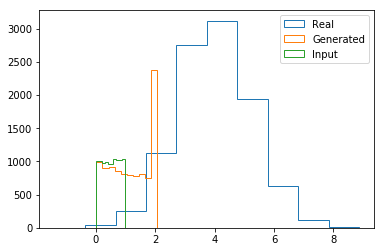

Stage 1 (Epoch:100)
Mean and Std of Real: (4.0025345514057085, 1.242382255338929)
Mean and Std of Gen: (2.5556934, 0.9918405)
Z.shape: (10, 100)
(10, 100)


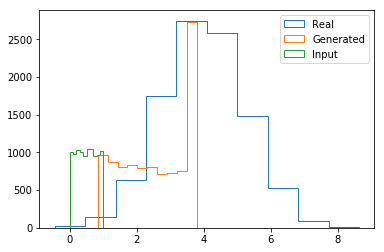

Stage 2 (Epoch:200)
Mean and Std of Real: (3.9971970454966192, 1.2539939309412578)
Mean and Std of Gen: (3.7174184, 1.1207741)
Z.shape: (10, 100)
(10, 100)


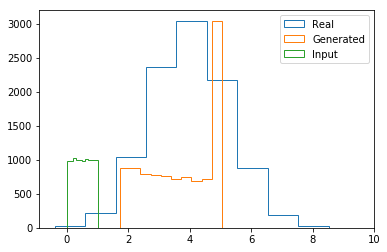

Stage 3 (Epoch:300)
Mean and Std of Real: (4.008634141564679, 1.2533888303002145)
Mean and Std of Gen: (3.6559336, 1.4517784)
Z.shape: (10, 100)
(10, 100)


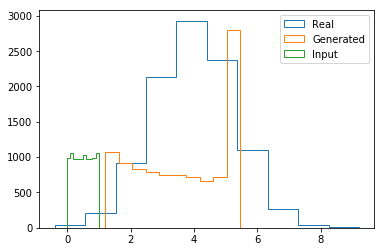

Stage 4 (Epoch:400)
Mean and Std of Real: (4.005422885782895, 1.263946763643609)
Mean and Std of Gen: (4.0095906, 1.3926418)
Z.shape: (10, 100)
(10, 100)


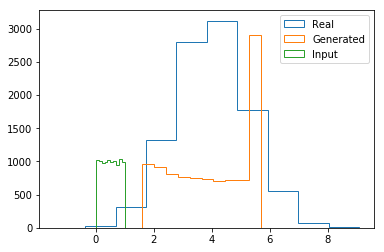

Stage 5 (Epoch:500)
Mean and Std of Real: (3.9924475886245876, 1.250211774486659)
Mean and Std of Gen: (4.6095376, 1.2087985)
Z.shape: (10, 100)
(10, 100)


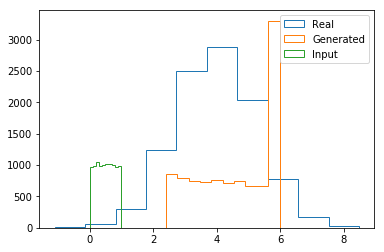

Stage 6 (Epoch:600)
Mean and Std of Real: (3.9965679255877955, 1.2350769562553885)
Mean and Std of Gen: (3.907357, 1.2935288)
Z.shape: (10, 100)
(10, 100)


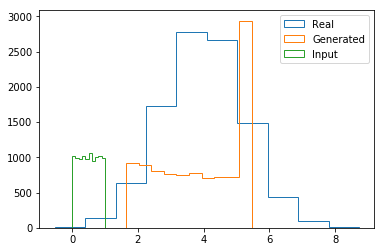

Stage 7 (Epoch:700)
Mean and Std of Real: (4.0116263774013206, 1.2543209420003165)
Mean and Std of Gen: (3.8244731, 1.3223377)
Z.shape: (10, 100)
(10, 100)


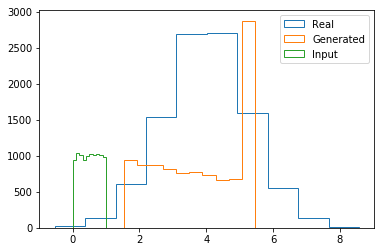

Stage 8 (Epoch:800)
Mean and Std of Real: (3.990512859271271, 1.246841297796821)
Mean and Std of Gen: (3.4477417, 1.3891268)
Z.shape: (10, 100)
(10, 100)


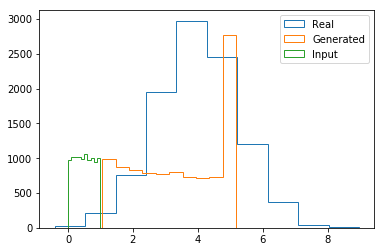

Stage 9 (Epoch:900)
Mean and Std of Real: (4.00981810349314, 1.2370988612690932)
Mean and Std of Gen: (3.3758602, 1.2857114)
Z.shape: (10, 100)
(10, 100)


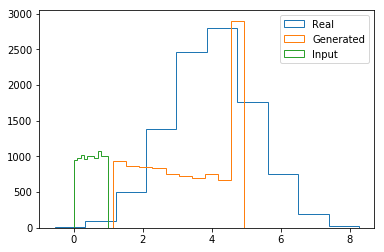

Stage 10 (Epoch:1000)
Mean and Std of Real: (4.01332789453584, 1.25990940909779)
Mean and Std of Gen: (3.922528, 0.98808056)
Z.shape: (10, 100)
(10, 100)


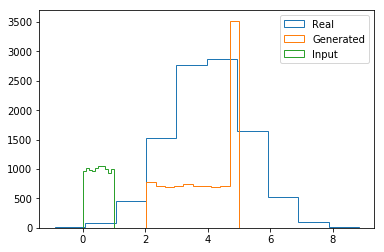

Stage 11 (Epoch:1100)
Mean and Std of Real: (3.999763345803821, 1.2480599180215854)
Mean and Std of Gen: (3.6803343, 1.0843283)
Z.shape: (10, 100)
(10, 100)


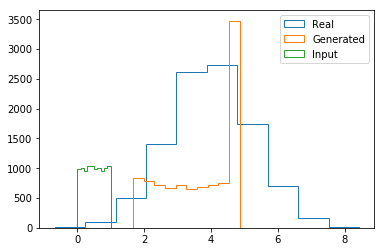

Stage 12 (Epoch:1200)
Mean and Std of Real: (3.9939485922621256, 1.2505470068071796)
Mean and Std of Gen: (3.255461, 1.1160024)
Z.shape: (10, 100)
(10, 100)


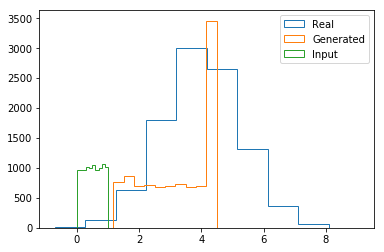

Stage 13 (Epoch:1300)
Mean and Std of Real: (3.990585093656392, 1.254526596182799)
Mean and Std of Gen: (3.754759, 1.0312346)
Z.shape: (10, 100)
(10, 100)


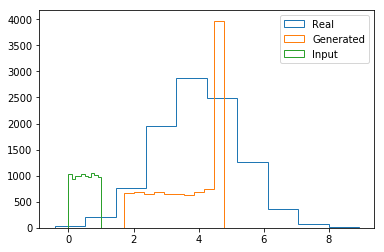

Stage 14 (Epoch:1400)
Mean and Std of Real: (3.990239422106748, 1.2466309604707158)
Mean and Std of Gen: (3.6671445, 1.1749822)
Z.shape: (10, 100)
(10, 100)


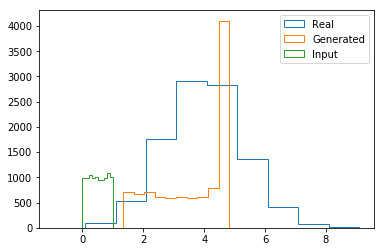

Stage 15 (Epoch:1500)
Mean and Std of Real: (4.009632665674146, 1.269757631854114)
Mean and Std of Gen: (3.7689335, 1.2752677)
Z.shape: (10, 100)
(10, 100)


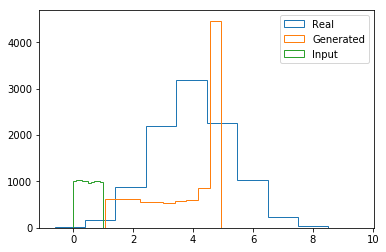

Stage 16 (Epoch:1600)
Mean and Std of Real: (4.012414100047877, 1.2425538587452474)
Mean and Std of Gen: (3.6674173, 1.2767128)
Z.shape: (10, 100)
(10, 100)


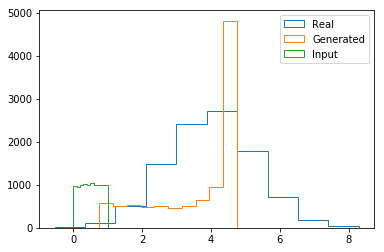

Stage 17 (Epoch:1700)
Mean and Std of Real: (4.020930401799813, 1.2424780413932761)
Mean and Std of Gen: (3.8647196, 1.2969084)
Z.shape: (10, 100)
(10, 100)


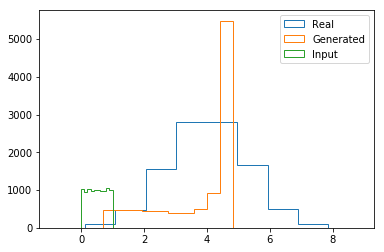

Stage 18 (Epoch:1800)
Mean and Std of Real: (4.011449459158931, 1.2473135884012403)
Mean and Std of Gen: (4.265084, 1.3684117)
Z.shape: (10, 100)
(10, 100)


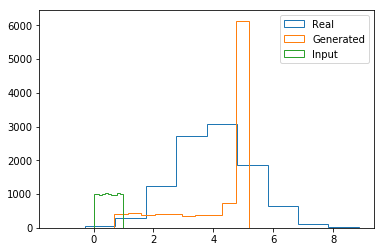

Stage 19 (Epoch:1900)
Mean and Std of Real: (3.9850689768277365, 1.2269325339915143)
Mean and Std of Gen: (4.834864, 1.3666046)
Z.shape: (10, 100)
(10, 100)


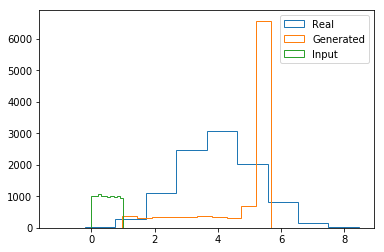

Stage 20 (Epoch:2000)
Mean and Std of Real: (3.9999564141291253, 1.2574537900817382)
Mean and Std of Gen: (4.898054, 1.3609264)
Z.shape: (10, 100)
(10, 100)


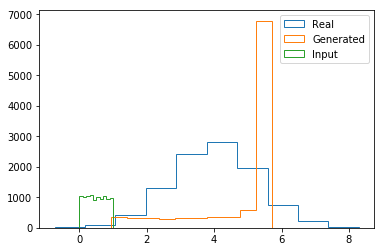

Stage 21 (Epoch:2100)
Mean and Std of Real: (3.985564206189944, 1.2405811107247513)
Mean and Std of Gen: (5.1405954, 1.3506525)
Z.shape: (10, 100)
(10, 100)


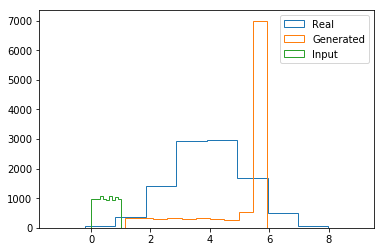

Stage 22 (Epoch:2200)
Mean and Std of Real: (3.999102280830171, 1.2582741895074312)
Mean and Std of Gen: (5.3653193, 1.4794981)
Z.shape: (10, 100)
(10, 100)


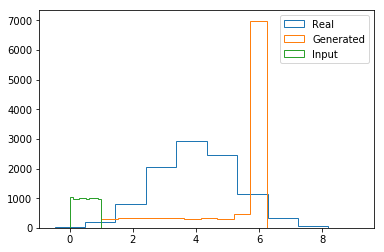

Stage 23 (Epoch:2300)
Mean and Std of Real: (3.998653498949783, 1.2430437141814503)
Mean and Std of Gen: (5.2142477, 1.4813983)
Z.shape: (10, 100)
(10, 100)


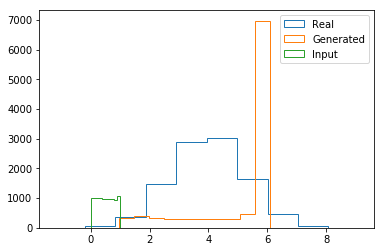

Stage 24 (Epoch:2400)
Mean and Std of Real: (4.013793146802855, 1.2537401524774034)
Mean and Std of Gen: (5.383867, 1.4254354)
Z.shape: (10, 100)
(10, 100)


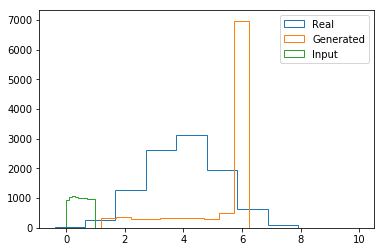

Stage 25 (Epoch:2500)
Mean and Std of Real: (3.9985452485036492, 1.2344141043466945)
Mean and Std of Gen: (4.9038415, 1.4730701)
Z.shape: (10, 100)
(10, 100)


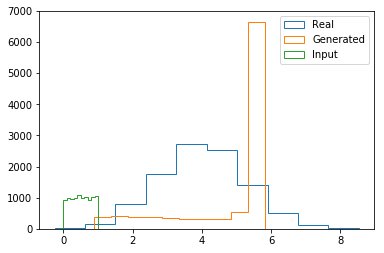

Stage 26 (Epoch:2600)
Mean and Std of Real: (3.9968072095205063, 1.2578469086931738)
Mean and Std of Gen: (5.3688917, 1.2711294)
Z.shape: (10, 100)
(10, 100)


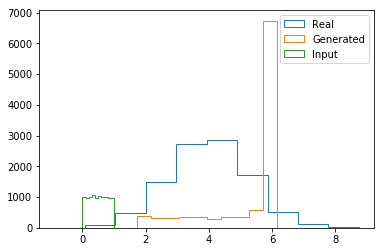

Stage 27 (Epoch:2700)
Mean and Std of Real: (3.9955269060834433, 1.2606022791062865)
Mean and Std of Gen: (5.255303, 1.3816892)
Z.shape: (10, 100)
(10, 100)


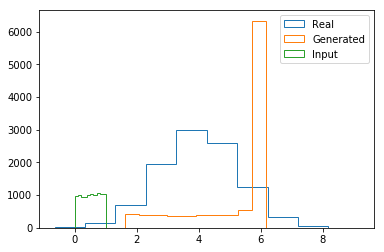

Stage 28 (Epoch:2800)
Mean and Std of Real: (3.9950823355958587, 1.2484473409477508)
Mean and Std of Gen: (4.950042, 1.4480971)
Z.shape: (10, 100)
(10, 100)


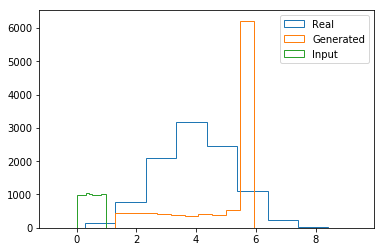

Stage 29 (Epoch:2900)
Mean and Std of Real: (3.9952406018875792, 1.2551452525186182)
Mean and Std of Gen: (4.8602057, 1.3522261)
Z.shape: (10, 100)
(10, 100)


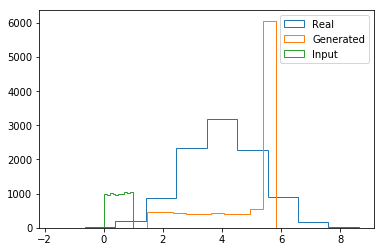

Stage 30 (Epoch:3000)
Mean and Std of Real: (4.030540633704177, 1.2464555206873076)
Mean and Std of Gen: (4.5448766, 1.3559563)
Z.shape: (10, 100)
(10, 100)


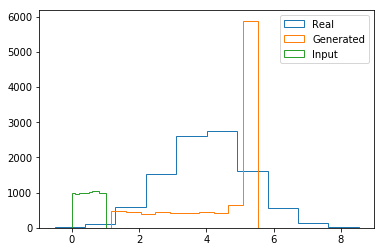

Stage 31 (Epoch:3100)
Mean and Std of Real: (4.006284536104029, 1.2561725382757116)
Mean and Std of Gen: (4.541849, 1.3812994)
Z.shape: (10, 100)
(10, 100)


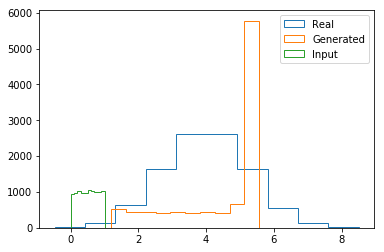

Stage 32 (Epoch:3200)
Mean and Std of Real: (3.992459707961142, 1.2532743942730626)
Mean and Std of Gen: (4.1740937, 1.3543862)
Z.shape: (10, 100)
(10, 100)


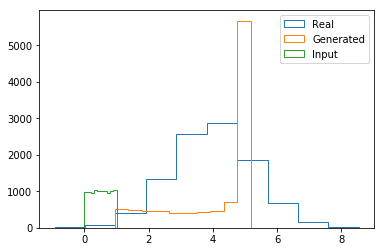

Stage 33 (Epoch:3300)
Mean and Std of Real: (3.978337769778747, 1.2515400785026647)
Mean and Std of Gen: (3.971747, 1.2604883)
Z.shape: (10, 100)
(10, 100)


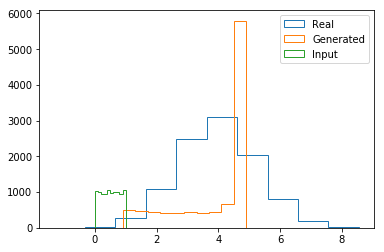

Stage 34 (Epoch:3400)
Mean and Std of Real: (3.997384327190212, 1.2562255683487569)
Mean and Std of Gen: (3.994839, 1.2685289)
Z.shape: (10, 100)
(10, 100)


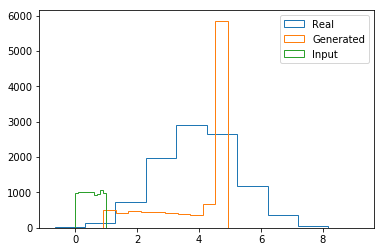

Stage 35 (Epoch:3500)
Mean and Std of Real: (4.008107477870359, 1.2593949775764866)
Mean and Std of Gen: (3.9572554, 1.2041463)
Z.shape: (10, 100)
(10, 100)


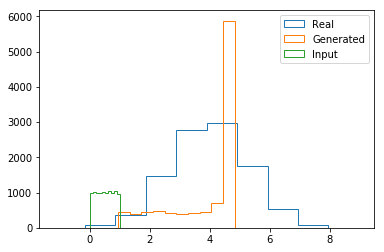

Stage 36 (Epoch:3600)
Mean and Std of Real: (3.9999870804379607, 1.2434474784051501)
Mean and Std of Gen: (3.7689524, 1.3261282)
Z.shape: (10, 100)
(10, 100)


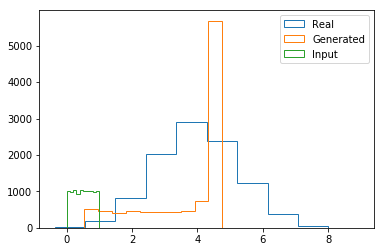

Stage 37 (Epoch:3700)
Mean and Std of Real: (3.9800418230013617, 1.2565052676972905)
Mean and Std of Gen: (3.9685106, 1.3212994)
Z.shape: (10, 100)
(10, 100)


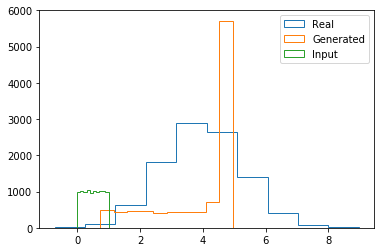

Stage 38 (Epoch:3800)
Mean and Std of Real: (3.999607879405158, 1.2507283874137685)
Mean and Std of Gen: (4.1188927, 1.2037202)
Z.shape: (10, 100)
(10, 100)


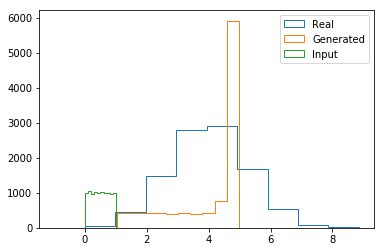

Stage 39 (Epoch:3900)
Mean and Std of Real: (4.00221102777218, 1.262366792447589)
Mean and Std of Gen: (4.079516, 1.2026782)
Z.shape: (10, 100)
(10, 100)


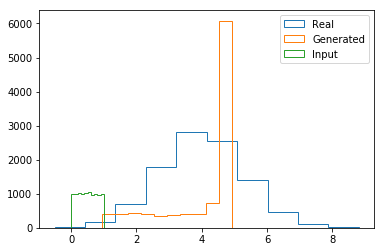

Stage 40 (Epoch:4000)
Mean and Std of Real: (3.98452244357534, 1.2512383678054084)
Mean and Std of Gen: (4.036008, 1.159109)
Z.shape: (10, 100)
(10, 100)


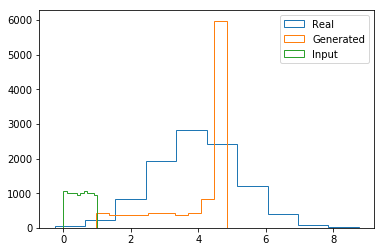

Stage 41 (Epoch:4100)
Mean and Std of Real: (4.012884566955899, 1.2630902368031647)
Mean and Std of Gen: (4.1026483, 1.3212397)
Z.shape: (10, 100)
(10, 100)


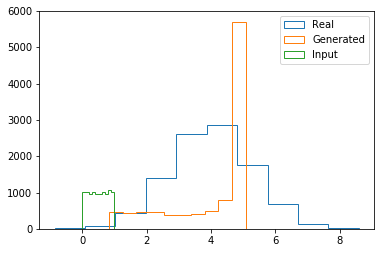

Stage 42 (Epoch:4200)
Mean and Std of Real: (3.9984645216150185, 1.2436411734436748)
Mean and Std of Gen: (4.2224765, 1.2418159)
Z.shape: (10, 100)
(10, 100)


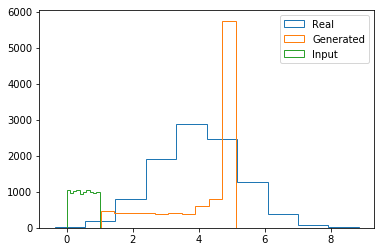

Stage 43 (Epoch:4300)
Mean and Std of Real: (4.008135423486186, 1.2584560455220741)
Mean and Std of Gen: (4.1346226, 1.2975435)
Z.shape: (10, 100)
(10, 100)


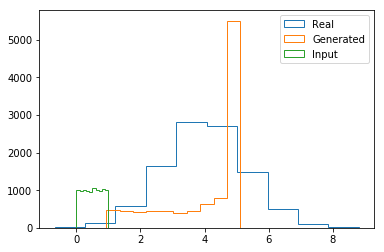

Stage 44 (Epoch:4400)
Mean and Std of Real: (4.01258520532177, 1.2710024319421838)
Mean and Std of Gen: (4.0996895, 1.1841571)
Z.shape: (10, 100)
(10, 100)


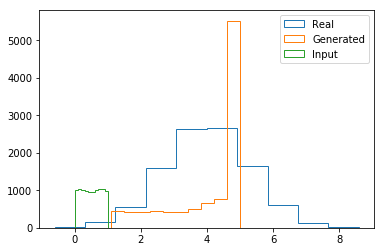

Stage 45 (Epoch:4500)
Mean and Std of Real: (3.999275126533938, 1.241274265180734)
Mean and Std of Gen: (3.8849835, 1.2333326)
Z.shape: (10, 100)
(10, 100)


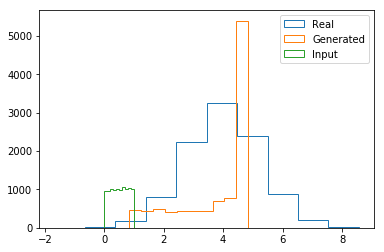

Stage 46 (Epoch:4600)
Mean and Std of Real: (3.9841581185793804, 1.2495628762784683)
Mean and Std of Gen: (3.9697382, 1.2209736)
Z.shape: (10, 100)
(10, 100)


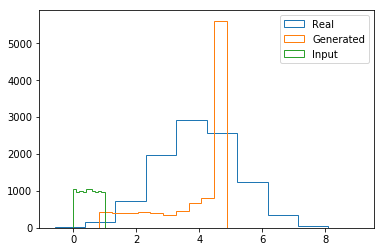

Stage 47 (Epoch:4700)
Mean and Std of Real: (3.9880456296493807, 1.2537548320490368)
Mean and Std of Gen: (3.9563625, 1.2491105)
Z.shape: (10, 100)
(10, 100)


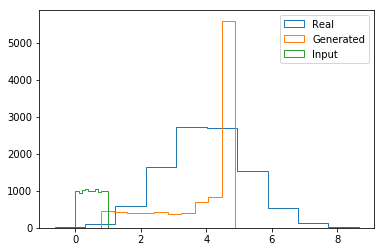

Stage 48 (Epoch:4800)
Mean and Std of Real: (3.9837665854085396, 1.2197355450781213)
Mean and Std of Gen: (3.8457222, 1.1601596)
Z.shape: (10, 100)
(10, 100)


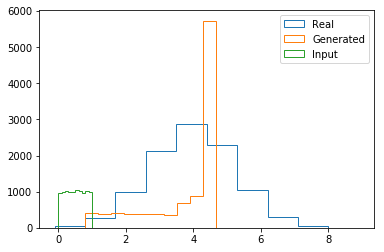

Stage 49 (Epoch:4900)
Mean and Std of Real: (3.9920569213795, 1.2473464871867936)
Mean and Std of Gen: (3.851697, 1.2354786)
Z.shape: (10, 100)
(10, 100)


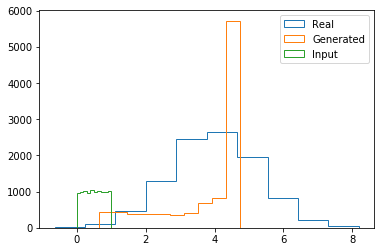

Stage 50 (Epoch:5000)
Mean and Std of Real: (3.9917895002134967, 1.2598247306967691)
Mean and Std of Gen: (3.709568, 1.2282588)
Z.shape: (10, 100)
(10, 100)


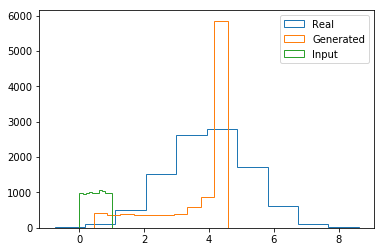

Stage 51 (Epoch:5100)
Mean and Std of Real: (3.998831897526013, 1.2660427751877832)
Mean and Std of Gen: (4.134176, 1.1884276)
Z.shape: (10, 100)
(10, 100)


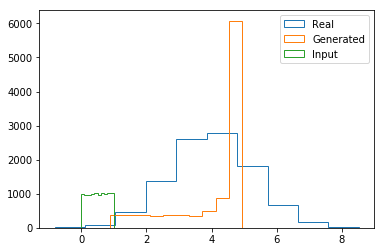

Stage 52 (Epoch:5200)
Mean and Std of Real: (3.985786396554985, 1.2522652213598306)
Mean and Std of Gen: (4.0835624, 1.278173)
Z.shape: (10, 100)
(10, 100)


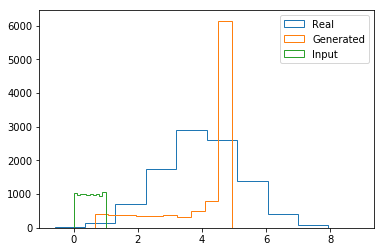

Stage 53 (Epoch:5300)
Mean and Std of Real: (3.9886425046193814, 1.2536026462655128)
Mean and Std of Gen: (4.2383494, 1.2082068)
Z.shape: (10, 100)
(10, 100)


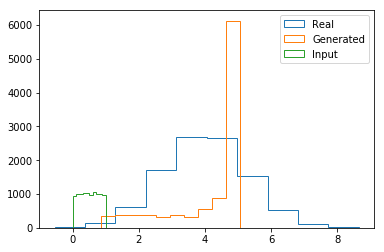

Stage 54 (Epoch:5400)
Mean and Std of Real: (4.0054155842475385, 1.2518498392608828)
Mean and Std of Gen: (4.0889487, 1.3969742)
Z.shape: (10, 100)
(10, 100)


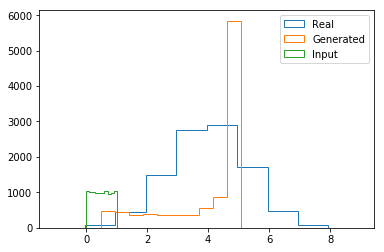

Stage 55 (Epoch:5500)
Mean and Std of Real: (4.017911890061242, 1.2502952881638165)
Mean and Std of Gen: (4.0541677, 1.2697581)
Z.shape: (10, 100)
(10, 100)


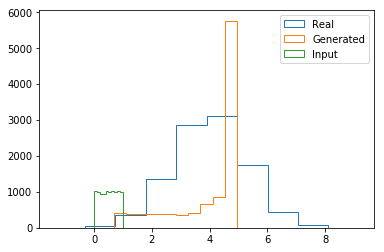

Stage 56 (Epoch:5600)
Mean and Std of Real: (3.996639710117213, 1.2457932987402693)
Mean and Std of Gen: (4.29324, 1.2502962)
Z.shape: (10, 100)
(10, 100)


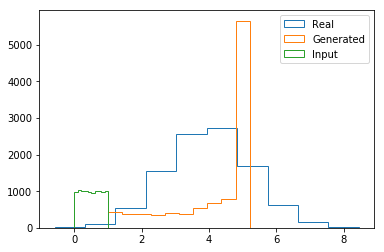

Stage 57 (Epoch:5700)
Mean and Std of Real: (4.0120626685576655, 1.241026162908837)
Mean and Std of Gen: (4.310542, 1.2403511)
Z.shape: (10, 100)
(10, 100)


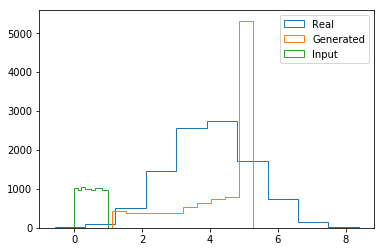

Stage 58 (Epoch:5800)
Mean and Std of Real: (4.014004745273372, 1.2579428960227577)
Mean and Std of Gen: (3.8305063, 1.2923954)
Z.shape: (10, 100)
(10, 100)


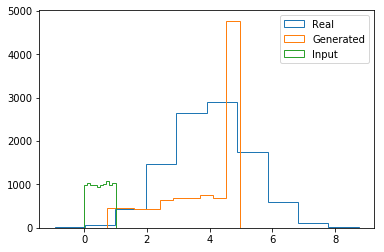

Stage 59 (Epoch:5900)
Mean and Std of Real: (3.9970866914140664, 1.250588233587485)
Mean and Std of Gen: (4.094064, 1.2799702)
Z.shape: (10, 100)
(10, 100)


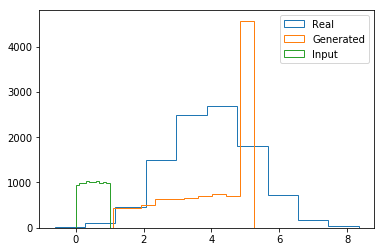

Stage 60 (Epoch:6000)
Mean and Std of Real: (3.986993227146223, 1.2453883377144612)
Mean and Std of Gen: (3.6468284, 1.3284041)
Z.shape: (10, 100)
(10, 100)


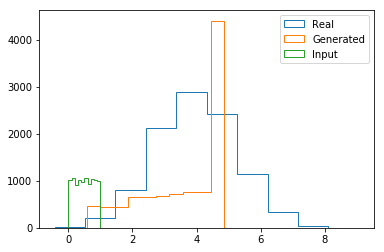

Stage 61 (Epoch:6100)
Mean and Std of Real: (3.9973340967540034, 1.254154101002032)
Mean and Std of Gen: (3.5236778, 1.2516434)
Z.shape: (10, 100)
(10, 100)


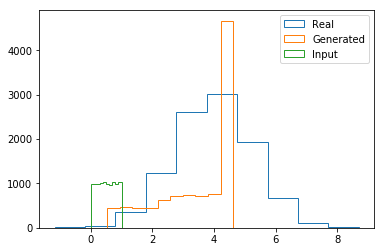

Stage 62 (Epoch:6200)
Mean and Std of Real: (4.011201881060493, 1.2648598516728005)
Mean and Std of Gen: (3.9101007, 1.2617221)
Z.shape: (10, 100)
(10, 100)


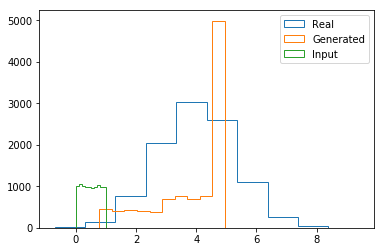

Stage 63 (Epoch:6300)
Mean and Std of Real: (3.9814831243898277, 1.248318687744646)
Mean and Std of Gen: (3.654775, 1.2952459)
Z.shape: (10, 100)
(10, 100)


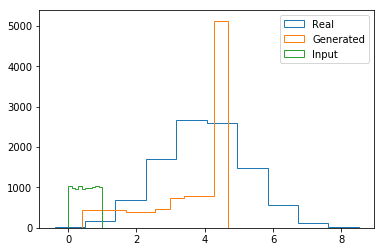

Stage 64 (Epoch:6400)
Mean and Std of Real: (4.0028110965992605, 1.237868763730744)
Mean and Std of Gen: (4.254703, 1.2440013)
Z.shape: (10, 100)
(10, 100)


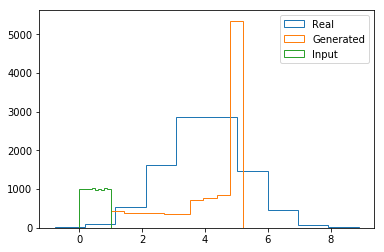

Stage 65 (Epoch:6500)
Mean and Std of Real: (3.9915524003081546, 1.2511964927989818)
Mean and Std of Gen: (3.7626235, 1.1703587)
Z.shape: (10, 100)
(10, 100)


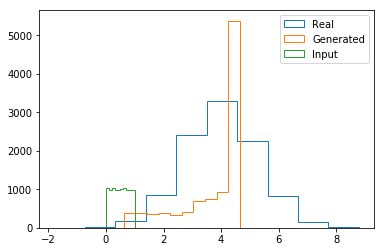

Stage 66 (Epoch:6600)
Mean and Std of Real: (3.999572791623477, 1.2494247500773576)
Mean and Std of Gen: (3.9776242, 1.1872001)
Z.shape: (10, 100)
(10, 100)


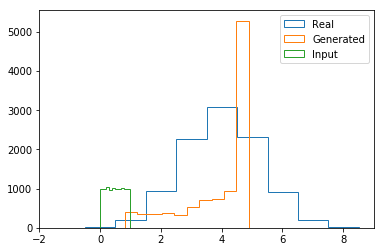

Stage 67 (Epoch:6700)
Mean and Std of Real: (3.9977262107408658, 1.24088370378574)
Mean and Std of Gen: (4.039312, 1.2421576)
Z.shape: (10, 100)
(10, 100)


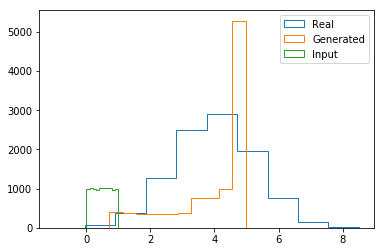

Stage 68 (Epoch:6800)
Mean and Std of Real: (4.002829216115072, 1.231691008499306)
Mean and Std of Gen: (4.04456, 1.2347397)
Z.shape: (10, 100)
(10, 100)


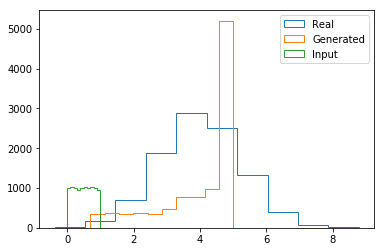

Stage 69 (Epoch:6900)
Mean and Std of Real: (3.9904569722664616, 1.2644208044897465)
Mean and Std of Gen: (3.9981496, 1.3487556)
Z.shape: (10, 100)
(10, 100)


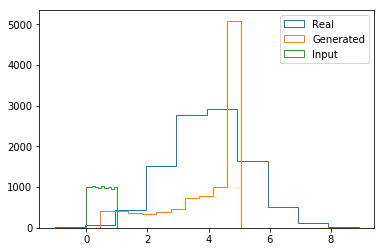

Stage 70 (Epoch:7000)
Mean and Std of Real: (4.008528020696745, 1.2379896233056276)
Mean and Std of Gen: (3.6984234, 1.3044294)
Z.shape: (10, 100)
(10, 100)


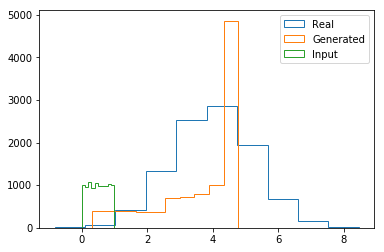

Stage 71 (Epoch:7100)
Mean and Std of Real: (3.9827450713811574, 1.267004090495672)
Mean and Std of Gen: (3.9624267, 1.2172915)
Z.shape: (10, 100)
(10, 100)


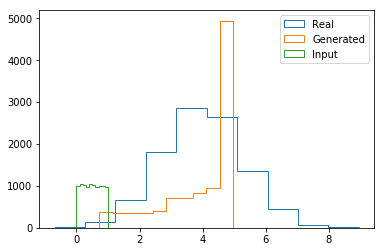

Stage 72 (Epoch:7200)
Mean and Std of Real: (3.996020400120647, 1.260110023753868)
Mean and Std of Gen: (3.9105484, 1.2768619)
Z.shape: (10, 100)
(10, 100)


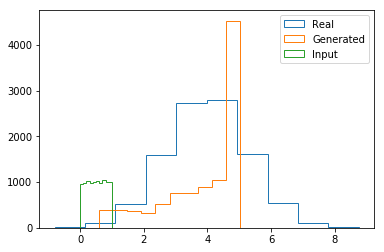

Stage 73 (Epoch:7300)
Mean and Std of Real: (4.002340494785248, 1.2496500315813122)
Mean and Std of Gen: (3.9740438, 1.2489415)
Z.shape: (10, 100)
(10, 100)


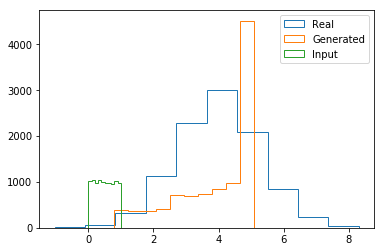

Stage 74 (Epoch:7400)
Mean and Std of Real: (3.9993077866066815, 1.2441058024639093)
Mean and Std of Gen: (4.0396557, 1.2666303)
Z.shape: (10, 100)
(10, 100)


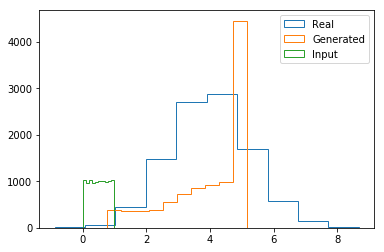

Stage 75 (Epoch:7500)
Mean and Std of Real: (4.017106194715266, 1.2452409129992508)
Mean and Std of Gen: (4.082966, 1.2427156)
Z.shape: (10, 100)
(10, 100)


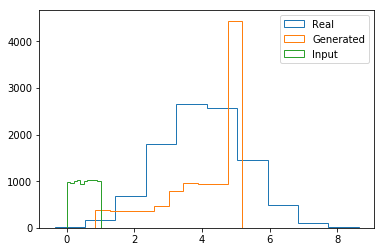

Stage 76 (Epoch:7600)
Mean and Std of Real: (3.987271437933057, 1.2474427904056777)
Mean and Std of Gen: (3.755592, 1.191945)
Z.shape: (10, 100)
(10, 100)


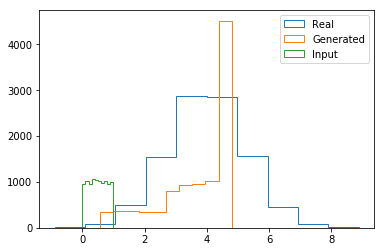

Stage 77 (Epoch:7700)
Mean and Std of Real: (4.007970829766696, 1.2370212124484778)
Mean and Std of Gen: (3.9226449, 1.3053199)
Z.shape: (10, 100)
(10, 100)


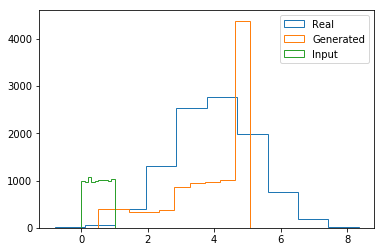

Stage 78 (Epoch:7800)
Mean and Std of Real: (4.012210324932134, 1.240563106930424)
Mean and Std of Gen: (4.1244297, 1.3008415)
Z.shape: (10, 100)
(10, 100)


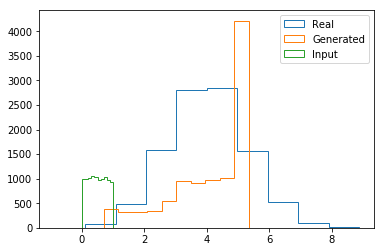

Stage 79 (Epoch:7900)
Mean and Std of Real: (3.991346353532845, 1.2360188297472747)
Mean and Std of Gen: (4.0248003, 1.1681824)
Z.shape: (10, 100)
(10, 100)


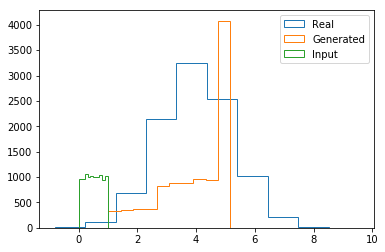

Stage 80 (Epoch:8000)
Mean and Std of Real: (3.998764338921864, 1.2580083191721374)
Mean and Std of Gen: (3.9677598, 1.2099187)
Z.shape: (10, 100)
(10, 100)


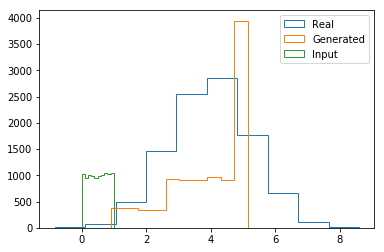

Stage 81 (Epoch:8100)
Mean and Std of Real: (4.000057273782873, 1.2352669582345808)
Mean and Std of Gen: (4.005884, 1.2422724)
Z.shape: (10, 100)
(10, 100)


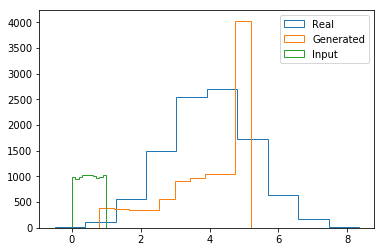

Stage 82 (Epoch:8200)
Mean and Std of Real: (4.0032939889794825, 1.242918172427881)
Mean and Std of Gen: (4.12963, 1.3157173)
Z.shape: (10, 100)
(10, 100)


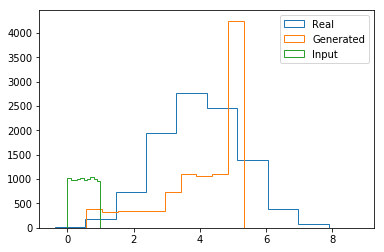

Stage 83 (Epoch:8300)
Mean and Std of Real: (4.006805211942487, 1.2476917485362775)
Mean and Std of Gen: (3.9604852, 1.1320395)
Z.shape: (10, 100)
(10, 100)


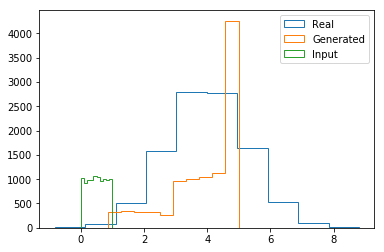

Stage 84 (Epoch:8400)
Mean and Std of Real: (3.9984903546950705, 1.2507414725935713)
Mean and Std of Gen: (4.239441, 1.1796148)
Z.shape: (10, 100)
(10, 100)


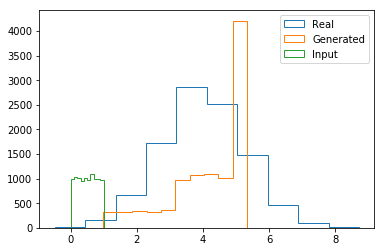

Stage 85 (Epoch:8500)
Mean and Std of Real: (4.023560765079698, 1.2643582379637575)
Mean and Std of Gen: (4.1036267, 1.2615665)
Z.shape: (10, 100)
(10, 100)


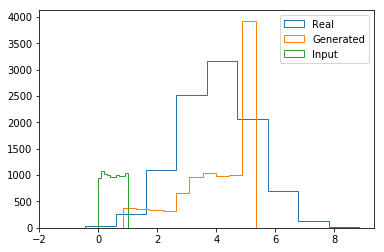

Stage 86 (Epoch:8600)
Mean and Std of Real: (3.9888631598905406, 1.258251352729113)
Mean and Std of Gen: (4.196923, 1.2795591)
Z.shape: (10, 100)
(10, 100)


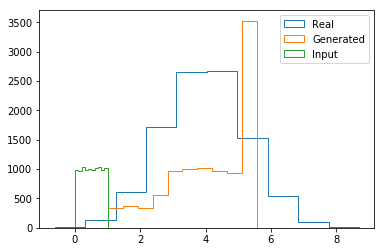

Stage 87 (Epoch:8700)
Mean and Std of Real: (3.993681188330047, 1.2569151578439741)
Mean and Std of Gen: (3.7095187, 1.22528)
Z.shape: (10, 100)
(10, 100)


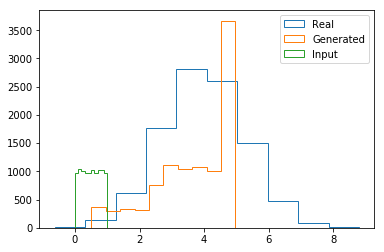

Stage 88 (Epoch:8800)
Mean and Std of Real: (3.998794722413266, 1.2584748565405874)
Mean and Std of Gen: (4.0492926, 1.2520591)
Z.shape: (10, 100)
(10, 100)


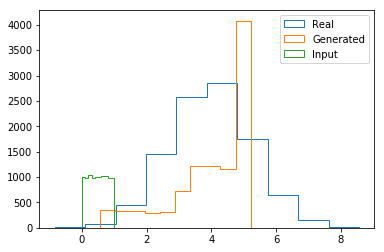

Stage 89 (Epoch:8900)
Mean and Std of Real: (3.9849601943143367, 1.2572995321833529)
Mean and Std of Gen: (3.9419472, 1.2731893)
Z.shape: (10, 100)
(10, 100)


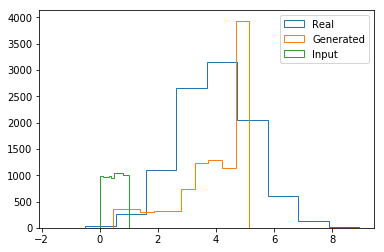

Stage 90 (Epoch:9000)
Mean and Std of Real: (3.9947476007020932, 1.248355079642524)
Mean and Std of Gen: (3.8157804, 1.2477783)
Z.shape: (10, 100)
(10, 100)


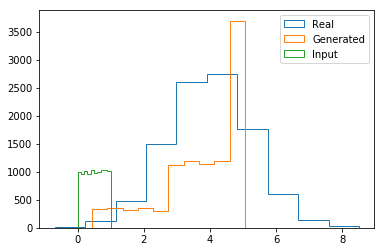

Stage 91 (Epoch:9100)
Mean and Std of Real: (3.993305842624944, 1.256212001085144)
Mean and Std of Gen: (4.1414113, 1.2507269)
Z.shape: (10, 100)
(10, 100)


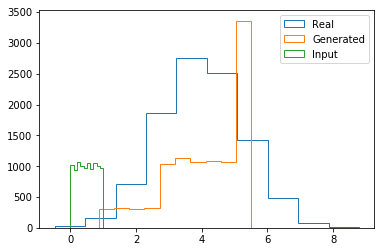

Stage 92 (Epoch:9200)
Mean and Std of Real: (3.985851341317169, 1.2517947355153107)
Mean and Std of Gen: (4.0610976, 1.3356595)
Z.shape: (10, 100)
(10, 100)


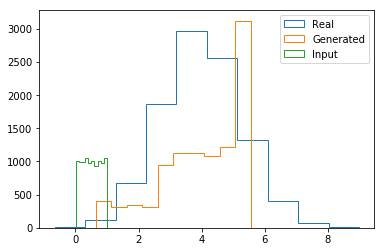

Stage 93 (Epoch:9300)
Mean and Std of Real: (3.9859710106813955, 1.2635969655889345)
Mean and Std of Gen: (4.3631043, 1.2307674)
Z.shape: (10, 100)
(10, 100)


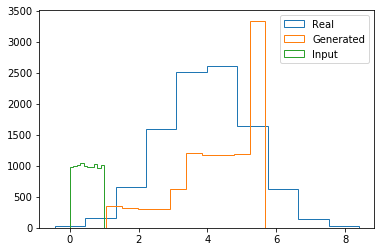

Stage 94 (Epoch:9400)
Mean and Std of Real: (3.9942277961828228, 1.260836079827411)
Mean and Std of Gen: (3.7334702, 1.2988802)
Z.shape: (10, 100)
(10, 100)


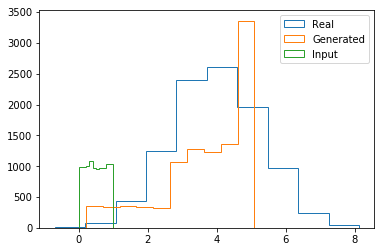

Stage 95 (Epoch:9500)
Mean and Std of Real: (3.997352200992671, 1.2436005495532627)
Mean and Std of Gen: (4.0325775, 1.2668492)
Z.shape: (10, 100)
(10, 100)


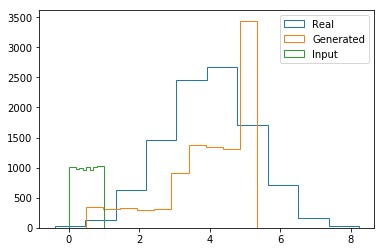

Stage 96 (Epoch:9600)
Mean and Std of Real: (4.005333770460888, 1.2426158097382092)
Mean and Std of Gen: (3.5594332, 1.2759392)
Z.shape: (10, 100)
(10, 100)


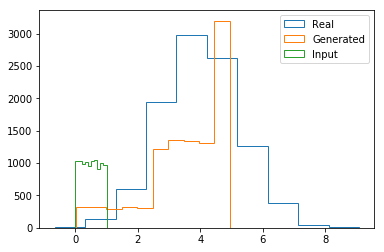

Stage 97 (Epoch:9700)
Mean and Std of Real: (4.00508659409697, 1.2595076918425108)
Mean and Std of Gen: (3.7743142, 1.3186791)
Z.shape: (10, 100)
(10, 100)


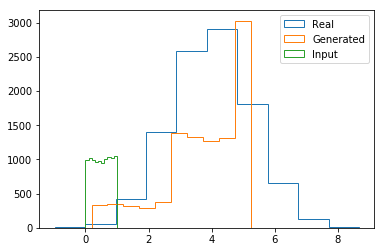

Stage 98 (Epoch:9800)
Mean and Std of Real: (4.002546619780635, 1.2694739509359239)
Mean and Std of Gen: (3.8114848, 1.2790506)
Z.shape: (10, 100)
(10, 100)


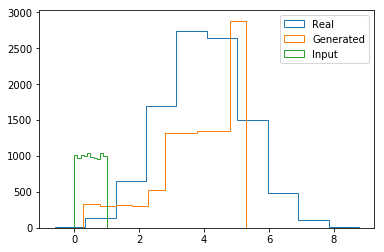

Stage 99 (Epoch:9900)
Mean and Std of Real: (3.9982936866199665, 1.2370926273543272)
Mean and Std of Gen: (4.079711, 1.2726538)
Z.shape: (10, 100)
(10, 100)


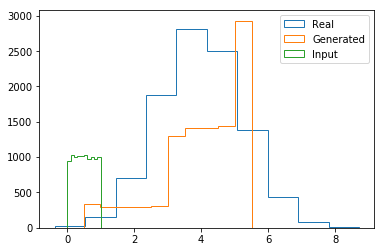

(100, 100)


In [25]:
if __name__ == '__main__':
    main()